In [1]:
from pathlib import Path
from jax import numpy as jnp

dnsbox_path = Path("/home/gokhan/codes/dnsbox/python")
import sys
sys.path.append(str(dnsbox_path.resolve()))
import dnsbox as dns

In [2]:
invariants = sorted(Path("/home/gokhan/codes/dnsbox.wiki/invariants").glob("./*/"))
target = Path("/mnt/c/Users/gokhan/Seafile/projects/dnsjax/invariants")

In [36]:
for invariant in invariants[:1]:
    number = invariant.name
    
    velocity_spec, header = dns.readState(invariant / "state.000000")

    nx, ny_half, nz, _ = velocity_spec.shape
    
    lam_spec = dns.laminar(1, nx, ny_half, nz)
    lam_phys = dns.fftSpecToPhysAll(lam_spec, supersample=True)
    lam_phys_dnsjax = jnp.moveaxis(lam_phys, [3, 1, 2, 0], [0, 1, 2, 3])

    _, nyy, nzz, nxx = lam_phys_dnsjax.shape

    # print(dns.inprod(lam_spec,lam_spec))
    # print(jnp.average(lam_phys[...,0]**2)/ 2)
    # print(jnp.average(lam_phys_dnsjax[0,...]**2)/ 2)
    
    velocity_phys = dns.fftSpecToPhysAll(velocity_spec, supersample=True)
    velocity_phys_dnsjax = jnp.moveaxis(velocity_phys, [3, 1, 2, 0], [0, 1, 2, 3])

    print(dns.inprod(velocity_spec,velocity_spec))
    print(jnp.average(jnp.sum(velocity_phys**2, axis=3))/ 2)
    print(jnp.average(jnp.sum(velocity_phys_dnsjax**2,axis=0))/ 2)

    Re = 628.3185307179584
    print("I", dns.powerin(velocity_spec,1,Re))
    print("D", dns.dissipation(velocity_spec,4,2,Re))

    # _, ny, nz, nx = velocity_phys_dnsjax.shape
    # velocity_phys_dnsjax *= 1/(nx*ny*nz)
    
    Path.mkdir(target / number, exist_ok=True)
    jnp.savez(target / number / "u0.npz", velocity_phys=velocity_phys_dnsjax, lam_phys=lam_phys_dnsjax)
    Path.copy(invariant / "parameters.in", target / number / "parameters.in")

0.026248105663956627
0.026248135
0.02624813
I 0.00030472561101708013
D 0.00030995481662392965


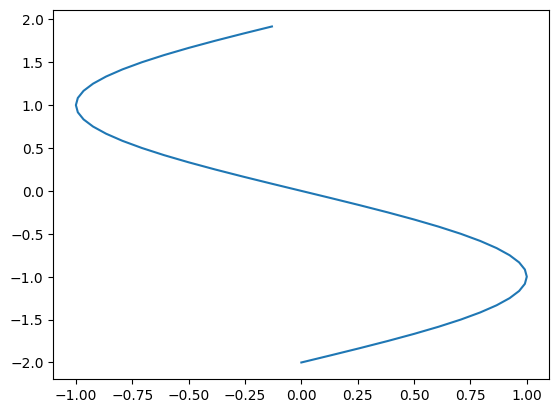

In [23]:
from matplotlib import pyplot as plt

ygrid = jnp.linspace(0, 4, ny_half*2, endpoint=False) - 4 / 2
fig, ax = plt.subplots()
ax.plot(lam_phys[0,:,0,0],ygrid)

In [4]:
# print(velocity_phys.shape)
# print("x", jnp.average(velocity_phys[0,:,:,0]**2))
# print("y", jnp.average(velocity_phys[:,0,:,1]**2))
# print("z", jnp.average(velocity_phys[:,:,0,2]**2))

# From x, y, z, ic
# Rotate to ic, y, z, x
# velocity_phys_dnsjax = jnp.moveaxis(velocity_phys, [3, 1, 2, 0], [0, 1, 2, 3])

# print("x", jnp.average(velocity_phys_dnsjax[0,:,:,0]**2))
# print("y", jnp.average(velocity_phys_dnsjax[1,0,:,:]**2))
# print("z", jnp.average(velocity_phys_dnsjax[2,:,0,:]**2))

In [5]:
velocity_phys_dnsjax.shape

(3, 72, 36, 72)

In [24]:
lam_phys[0,:,0,0]

array([ 0.        ,  0.13052619,  0.25881905,  0.38268343,  0.5       ,
        0.60876143,  0.70710678,  0.79335334,  0.8660254 ,  0.92387953,
        0.96592583,  0.99144486,  1.        ,  0.99144486,  0.96592583,
        0.92387953,  0.8660254 ,  0.79335334,  0.70710678,  0.60876143,
        0.5       ,  0.38268343,  0.25881905,  0.13052619,  0.        ,
       -0.13052619, -0.25881905, -0.38268343, -0.5       , -0.60876143,
       -0.70710678, -0.79335334, -0.8660254 , -0.92387953, -0.96592583,
       -0.99144486, -1.        , -0.99144486, -0.96592583, -0.92387953,
       -0.8660254 , -0.79335334, -0.70710678, -0.60876143, -0.5       ,
       -0.38268343, -0.25881905, -0.13052619])

In [26]:
jnp.average(lam_phys[0,:,0,0]**2)/2

Array(0.25000003, dtype=float32)

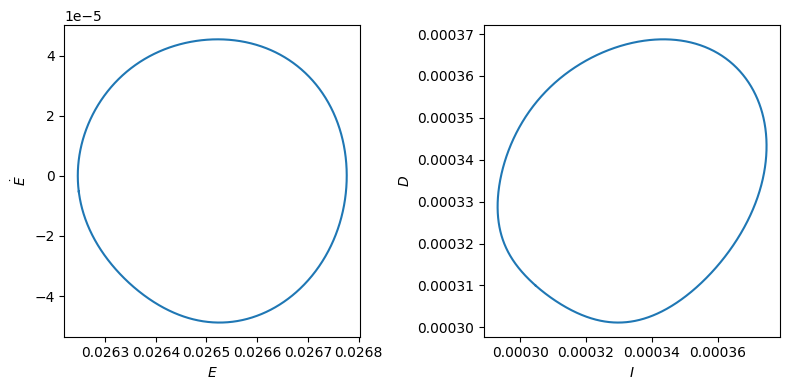

In [21]:
stats = jnp.load(target / "01" / "stats.npz")["stats_all"]

from matplotlib import pyplot as plt
fig, axs = plt.subplots(ncols=2, figsize=[8,4])

ax = axs[0]
ax.plot(stats[:,1], stats[:, 2] - stats[:, 3])
ax.set_xlabel("$E$")
ax.set_ylabel("$\\dot{E}$")

ax = axs[1]
ax.plot(stats[:,2], stats[:, 3])
ax.set_xlabel("$I$")
ax.set_ylabel("$D$")

fig.tight_layout()
fig.savefig("po.png")